In [134]:
import edward as ed
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from edward.models import Normal

from keras.layers import Input, Dense
from keras.regularizers import l2
from keras import backend as K

from sklearn.preprocessing import scale, StandardScaler
from scipy.stats import norm
from scipy import stats

from IPython.core.pylabtools import figsize

%matplotlib inline
plt.style.use('seaborn')


In [289]:
# ---- Minimize root MSE (RMSE) between log pred value and log sales prices ----

data = properties_df = pd.read_csv('train.csv',low_memory=False)
data.shape

(1460, 81)

In [290]:
keep_cols = data.columns[data.isnull().mean() < .25]
data = data[keep_cols]
cols = [col for col in data.columns if data[col].dtype == np.float64]
data.fillna(0);

In [260]:
prices = data['SalePrice']

Skewness: 1.882876
Kurtosis: 6.536282


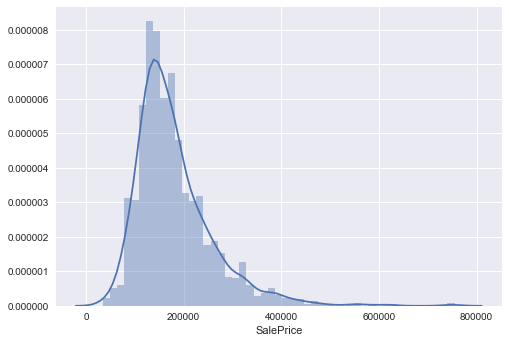

In [261]:
sns.distplot(prices)
print('Skewness: %f' % prices.skew())
print('Kurtosis: %f' % prices.kurt())

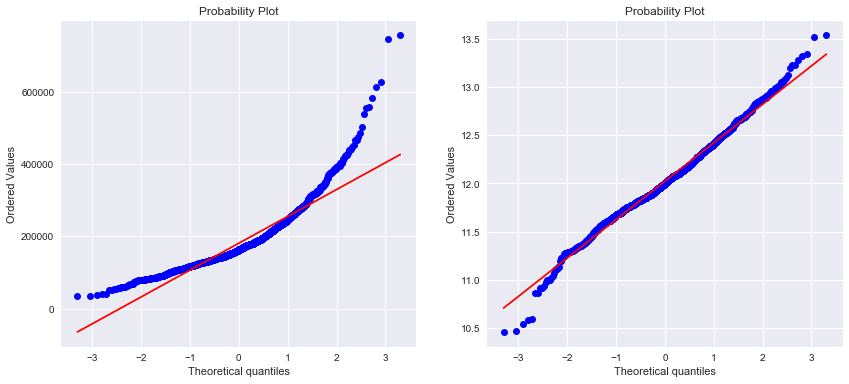

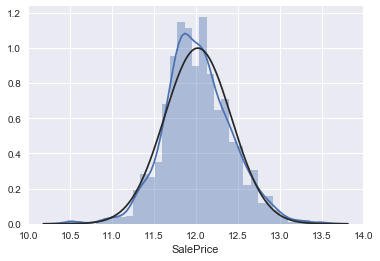

In [49]:
figsize(14, 6)
plt.figure();
plt.subplot(121);
stats.probplot(prices, plot=plt);
plt.subplot(122);
stats.probplot(np.log(prices), plot=plt); # log transform gets rid of (positive) skewness 
figsize(6,4)
plt.figure();
sns.distplot(np.log(prices), fit=norm)

In [296]:
# log-transform values with positive skewness
sk = []
loglist = []
num_data= []
for ind in np.arange(data.shape[1]):
    cl = data[data.columns[ind]]
    try:
        sk.append(cl.skew())
        if cl.skew() > 0.5: # arbitrary skewness threshold
#             data[data.columns[ind]] = np.log(cl)
            loglist.append(data.columns[ind])
        num_data.append(data.columns[ind])
    except:
        a = 1

data['SalePrice'] = np.log(data['SalePrice'])

C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [320]:
# model! 
# RNN/LSTM for data-wise updates?

def neural_network(x):
    h = tf.tanh(tf.matmul(x, W0) + b0)
    h = tf.tanh(tf.matmul(h, W1) + b1)
    h = (tf.matmul(h, W2) + b2)
    return tf.reshape(h, [-1])
    
N = data.shape[0]
# D = data.shape[1]
D = len(num_data)
# D = len(sk) # length of numeric features
h1Size = 10 # hidden layer size
h2Size = 10 # 2nd layer size
    
train_data = data[num_data]
train_data.drop('SalePrice', axis=1)
train_data = np.asarray(train_data)

# train_length = 200
# train_data = train_data[:train_length, :]

prices = scale(np.asarray(data['SalePrice']))
# prices = prices[:train_length]

W0 = Normal(loc=tf.zeros([D, h1Size]), scale=tf.ones([D, h1Size]))
W1 = Normal(loc=tf.zeros([h1Size, h2Size]), scale=tf.ones([h1Size, h2Size]))
W2 = Normal(loc=tf.zeros([h2Size, 1]), scale=tf.ones([h2Size, 1]))
b0 = Normal(loc=tf.zeros([h1Size]), scale=tf.ones([h1Size]))
b1 = Normal(loc=tf.zeros([h2Size]), scale=tf.ones([h2Size]))
b2 = Normal(loc=tf.zeros([1]), scale=tf.ones([1]))

x = tf.cast(train_data, tf.float32)
y = Normal(loc=neural_network(x), scale=0.1*tf.ones(1))


In [321]:
qW0 = Normal(loc=tf.Variable(tf.zeros([D, h1Size])),
             scale=tf.nn.softplus(tf.Variable(tf.ones([D, h1Size]))))
qW1 = Normal(loc=tf.Variable(tf.zeros([h1Size, h2Size])),
             scale=tf.nn.softplus(tf.Variable(tf.ones([h1Size, h2Size]))))
qW2 = Normal(loc=tf.Variable(tf.zeros([h2Size, 1])),
             scale=tf.nn.softplus(tf.Variable(tf.ones([h2Size, 1]))))
qb0 = Normal(loc=tf.Variable(tf.zeros([h1Size])), 
             scale=tf.nn.softplus(tf.Variable(tf.ones([h1Size]))))
qb1 = Normal(loc=tf.Variable(tf.zeros([h2Size])),
             scale=tf.nn.softplus(tf.Variable(tf.ones([h2Size]))))
qb2 = Normal(loc=tf.Variable(tf.zeros([1])),
             scale=tf.nn.softplus(tf.Variable(tf.ones([1]))))

In [322]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)
tf.global_variables_initializer().run()

In [323]:
latent_vars = {
    W0: qW0, W1: qW1, W2: qW2,
    b0: qb0, b1: qb1, b2: qb2
}

y_ph = tf.placeholder(tf.float32, shape=None)
X = tf.placeholder(tf.float32, shape=[None, D])

In [324]:
inference = ed.KLqp(latent_vars, data={y_ph: prices})

In [325]:
inference.run(n_samples=5, n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 8s | Loss: -0.000


In [326]:
y_post = ed.copy(y, latent_vars)

In [327]:
print(ed.evaluate('mean_squared_error', data={y_post: prices}))

nan


In [ ]:
plt.hist(y_post.sample(1).eval())

KeyboardInterrupt: 